In [13]:
import numpy as np
from matplotlib import pyplot as plt

def show_as_image(binary_image, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(binary_image, cmap='gray')
    plt.xticks([]); plt.yticks([])

%matplotlib inline

In [2]:
! mkdir ./data
! mkdir ./data/all
# git clone git@github.com:encharm/Font-Awesome-SVG-PNG.git
! cp ./Font-Awesome-SVG-PNG/black/png/16/* ./data/all

mkdir: cannot create directory ‘./data’: File exists
mkdir: cannot create directory ‘./data/all’: File exists


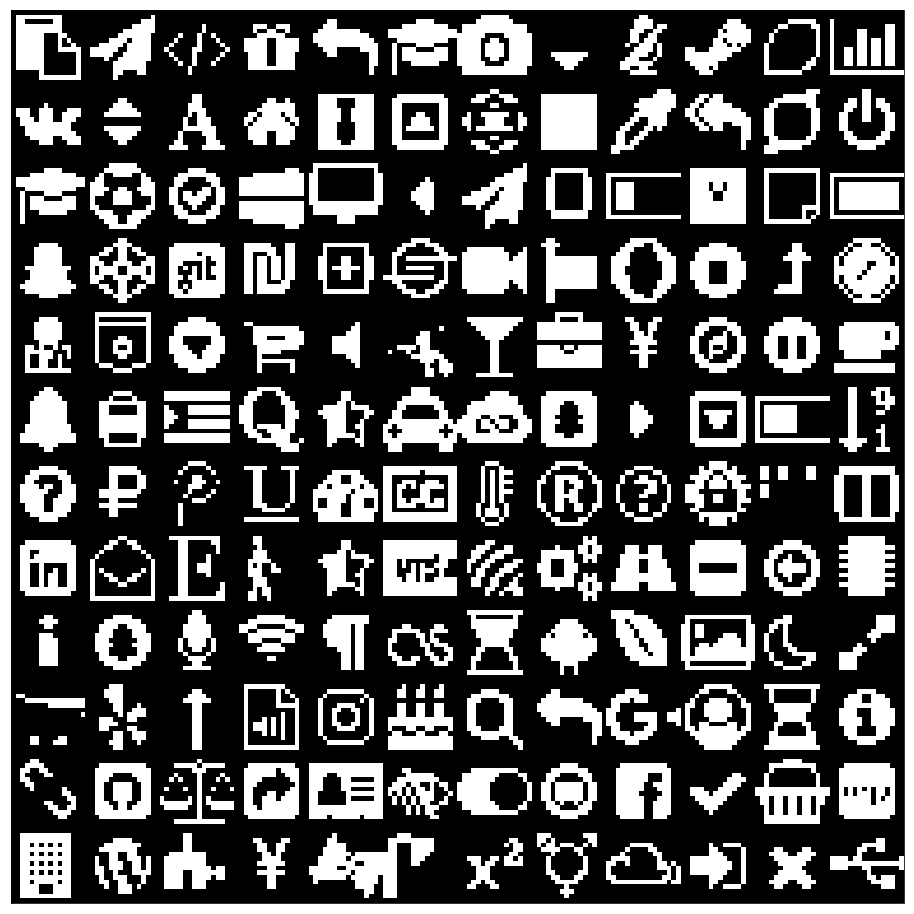

In [3]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler
from torchvision import transforms
from PIL import Image

la_loader = lambda _: Image.open(_).convert('LA')

image_dataset = datasets.folder.ImageFolder(
    './data', 
    transform=transforms.Lambda(lambda image: transforms.ToTensor()(image.crop(box=(0, 0, 16, 16)))[1:, :, :] > .5),
    loader=la_loader)

batch_images, labels = next(b for b in DataLoader(image_dataset, sampler=RandomSampler(image_dataset), batch_size=144))

def batch_images_to_one(batches_images):
    n_square_elements = int(np.sqrt(batches_images.shape[0]))
    rows_images = np.split(np.squeeze(batches_images), n_square_elements)
    return np.vstack([np.hstack(row_images) for row_images in rows_images])

show_as_image(batch_images_to_one(batch_images.numpy()), figsize=(16, 17))


In [4]:
import torch
import torch.nn as nn

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)
    
class PixelCNN(nn.Module):
    n_channels = 16
    kernel_size = 7
    padding = 3
    n_pixels_out = 2 # binary 0/1 pixels

    def __init__(self):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_pixels_out, kernel_size=1)
        )

    def forward(self, x):
        pixel_logits = self.layers(x)
        return pixel_logits

In [7]:
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler


N_EPOCHS = 80
BATCH_SIZE = 128
LR = 0.005
TEST_RATIO = .2

cnn = PixelCNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

test_indices = np.random.choice(len(image_dataset), size=int(len(image_dataset) * TEST_RATIO), replace=False)
train_indices = np.setdiff1d(np.arange(len(image_dataset)), test_indices)
train_loader = DataLoader(image_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indices=train_indices))
test_loader = DataLoader(image_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indices=test_indices))

for epoch in range(N_EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.float()
        optimizer.zero_grad()
        loss = F.cross_entropy(input=cnn(images), target=torch.squeeze(images).long())
        loss.backward()
        optimizer.step()
        
    test_images = next(i for i, _ in test_loader).float()
    test_loss =F .cross_entropy(input=cnn(test_images), target=torch.squeeze(test_images).long())

    print ('Epoch [%d/%d], Train loss: %.4f, Test loss: %.4f'
           %(epoch+1, N_EPOCHS, loss.item(), test_loss.item()))

Epoch [1/80], Train loss: 0.6159, Test loss: 0.5907
Epoch [2/80], Train loss: 0.5473, Test loss: 0.5373
Epoch [3/80], Train loss: 0.5116, Test loss: 0.5042
Epoch [4/80], Train loss: 0.4968, Test loss: 0.4879
Epoch [5/80], Train loss: 0.4776, Test loss: 0.4708
Epoch [6/80], Train loss: 0.4660, Test loss: 0.4644
Epoch [7/80], Train loss: 0.4404, Test loss: 0.4491
Epoch [8/80], Train loss: 0.4334, Test loss: 0.4271
Epoch [9/80], Train loss: 0.4065, Test loss: 0.3863
Epoch [10/80], Train loss: 0.3812, Test loss: 0.3546
Epoch [11/80], Train loss: 0.3563, Test loss: 0.3269
Epoch [12/80], Train loss: 0.3182, Test loss: 0.3060
Epoch [13/80], Train loss: 0.3056, Test loss: 0.2763
Epoch [14/80], Train loss: 0.3076, Test loss: 0.2685
Epoch [15/80], Train loss: 0.2681, Test loss: 0.2560
Epoch [16/80], Train loss: 0.2691, Test loss: 0.2428
Epoch [17/80], Train loss: 0.2513, Test loss: 0.2416
Epoch [18/80], Train loss: 0.2625, Test loss: 0.2370
Epoch [19/80], Train loss: 0.2475, Test loss: 0.2419
Ep

## Completing images

In [10]:
# pixelCNN로 새로운 샘플 만들기
# 어떤 특정한 이미지를 pixelCNN의 input으로 줄 수도 있고 아니면 그냥 zeros를 넣어 줄 수도 있다.
# pixelCNN은 input으로 주어진 이미지를 Masked Convolution으로 흝고 지나가면서 자신의 기억속에 존재하는, 가장 그럴듯한 픽셀 값을 예측해 낸다.
def generate_samples(n_samples, starting_point=(0, 0), starting_image=None):
    samples = torch.from_numpy(
        starting_image if starting_image is not None else np.zeros((n_samples * n_samples, 1, IMAGE_WIDTH, IMAGE_HEIGHT))).float()

    cnn.train(False)

    # pixelCNN이 예측한 pixel-level distribution으로 부터 픽셀 값(0 또는 1)을 샘플링해서 이미지를 만들어 낸다.
    for i in range(IMAGE_WIDTH):
        for j in range(IMAGE_HEIGHT):
            if i < starting_point[0] or (i == starting_point[0] and j < starting_point[1]):
                continue
            out = cnn(samples)
            probs = F.softmax(out[:, :, i, j],1).data
            samples[:, :, i, j] = torch.multinomial(probs, 1).float()
    return samples.numpy()

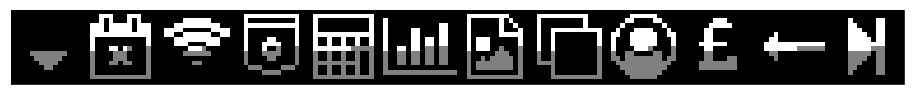

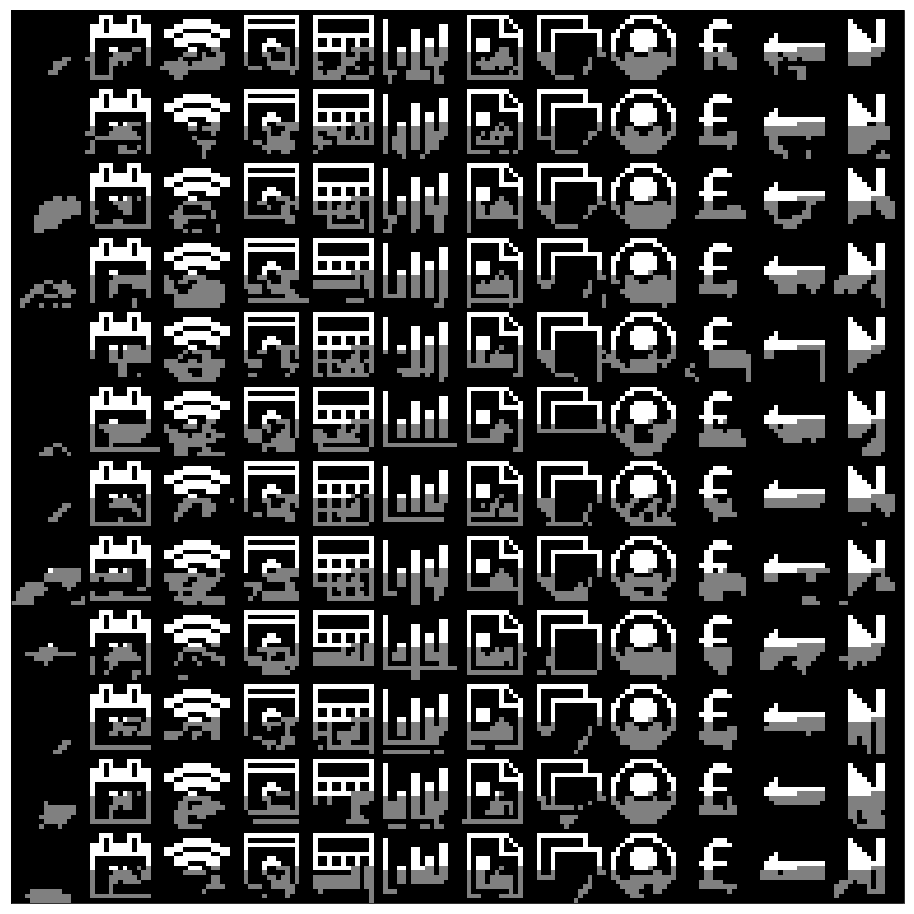

In [11]:
n_images = 12
batch_images, labels = next(b for b in train_loader)
batch_images = batch_images[:n_images, :, :, :]
IMAGE_WIDTH=16
IMAGE_HEIGHT=16
starting_point = (8, 8)

row_grid, col_grid = np.meshgrid(np.arange(16), np.arange(16), indexing='ij')
mask = np.logical_or(row_grid < starting_point[0], np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))

starting_images = batch_images.numpy().squeeze()
batch_starting_images = np.expand_dims(np.stack([i * mask for i in starting_images] * n_images), axis=1)

samples = generate_samples(10, starting_image=batch_starting_images, starting_point=starting_point)

show_as_image(np.hstack([(1 + mask) * i for i in starting_images]), figsize=(16, 17))

show_as_image(
    batch_images_to_one((samples * (1 + mask))),
    figsize=(16, 17))

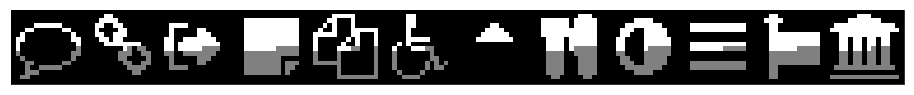

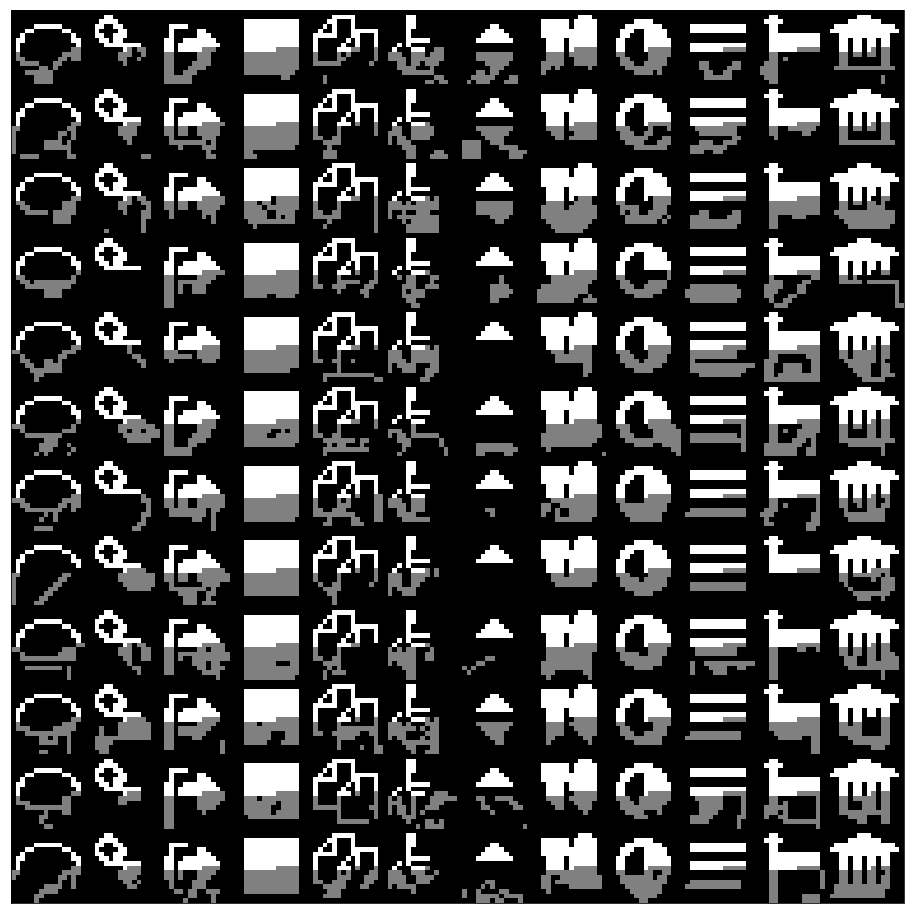

In [12]:
n_images = 12
batch_images, labels = next(b for b in test_loader)
batch_images = batch_images[:n_images, :, :, :]

starting_point = (8, 8)

row_grid, col_grid = np.meshgrid(np.arange(IMAGE_WIDTH), np.arange(IMAGE_HEIGHT), indexing='ij')
mask = np.logical_or(row_grid < starting_point[0], np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))

starting_images = batch_images.numpy().squeeze()
batch_starting_images = np.expand_dims(np.stack([i * mask for i in starting_images] * n_images), axis=1)

samples = generate_samples(10,starting_image=batch_starting_images, starting_point=starting_point)

show_as_image(np.hstack([(1 + mask) * i for i in starting_images]), figsize=(16, 17))

show_as_image(
    batch_images_to_one((samples * (1 + mask))),
    figsize=(16, 17))

## Generating new samples

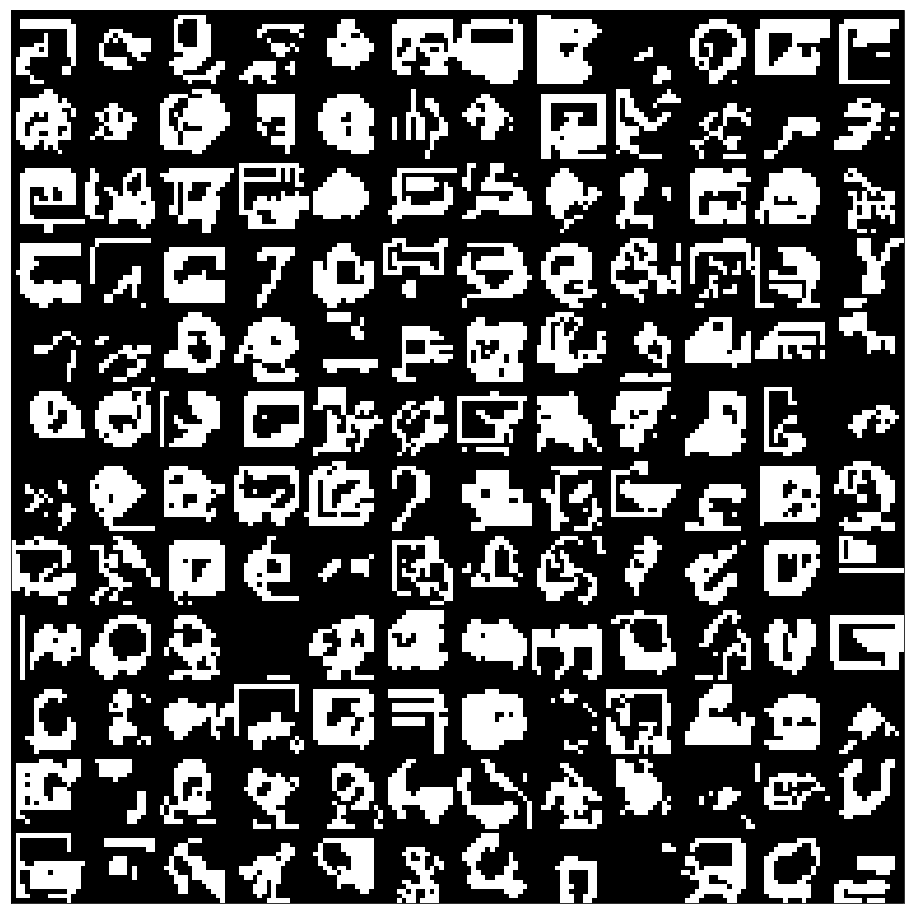

In [14]:
IMAGE_WIDTH, IMAGE_HEIGHT = 16, 16

def generate_samples(n_samples=12, starting_point=(0, 0), starting_image=None):

    samples = torch.from_numpy(
        starting_image if starting_image is not None else np.zeros((n_samples * n_samples, 1, IMAGE_WIDTH, IMAGE_HEIGHT))).float()

    cnn.train(False)

    for i in range(IMAGE_WIDTH):
        for j in range(IMAGE_HEIGHT):
            if i < starting_point[0] or (i == starting_point[0] and j < starting_point[1]):
                continue
            out = cnn(samples)
            probs = F.softmax(out[:, :, i, j],1).data
            samples[:, :, i, j] = torch.multinomial(probs, 1).float()
    return samples.numpy()

samples = generate_samples(12)

show_as_image(
    batch_images_to_one(samples),
    figsize=(16, 17))
